## Sidewalk Labs Case Study
Written by: Emily Porter

### DATA NOTES

##### Data source:http://data.un.org/Explorer.aspx -> Energy Statistics Database

##### Additional helpful source: https://unstats.un.org/unsd/energystats/methodology/documents/IRES-web.pdf

##### Data details: https://unstats.un.org/unsd/energystats/questionnaire/documents/Energy-Questionnaire-Guidelines.pdf
* Information from data details PDF:
    * 2 types of electricity generation plants of interest (there is a 3rd type that only produces heat)
        * Electricity plants: only produce electricity
        * Combined heat and power plants: produce electricity and heat

##### NOTES
###### Question 1: Global electricity generation by source in 2018
* Electricity generation information for hydro, nuclear, solar, and wind can be found in 'Total Electricity' file
* Electricity generation from coal:
    * Hard coal (anthracite, corking coal, and other bituminous coal)
    * Brown coal (sub-bituminous coal and lignite)
* Electricity generation from oil:
    * Conventional crude oil
* Electricity generation from natural gas:
    * Natural gas including liquid natural gas
* Electricity generation from biofuels:
    * Charcoal
    * Bagasse
    * Animal waste
    * Other vegetal material
    * Municipal waster
    * Industrial waste
    * Black liquor
    * Biogasoline
    * Biodiesel
    * Bio jet kersone
    * Other liquid biofuels
    * Biogases


In [1]:
%run plot_settings.ipynb

In [110]:
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
import requests
import numpy as np
from functools import reduce
import matplotlib.ticker as ticker


### Question 1: Percentage of global electricity generation (in 2018) by source
* Coal
* Oil 
* Natural Gas 
* Biofuels
* Hydro
* Nuclear 
* Solar
* Wind

In [196]:
# read data from UN site: http://data.un.org/Explorer.aspx 

url_base = 'http://data.un.org/Data.aspx?d=EDATA&f=cmID%3a'
url_year = '%3byr%3a2018'
url_page ='&s=_crEngNameOrderBy:asc,_enID:asc,yr:desc&v='
source_to_code_file = 'source_to_code_2.csv'
source_to_code = pd.read_csv(source_to_code_file)
source_weight_to_energy_file = 'source_weight_to_energy.csv'
source_weight_to_energy = pd.read_csv(source_weight_to_energy_file)
power_plant_efficiency_file = 'source_to_efficiency.csv'
power_plant_eff = pd.read_csv(power_plant_efficiency_file)
tj_to_gwh = 1/3.6

In [4]:
all_sources_list = []
for source, code in zip(source_to_code['Source'], source_to_code['Code']):
    url = url_base +code + url_year
    page = requests.get(url)
    # http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aNG%3bcrID%3a51
    soup = BeautifulSoup(page.content, 'html.parser')
    number_of_pages = soup.find('span', {'id':'spanPageCountB'}).get_text()
    df_list = []
    for i in range(1, int(number_of_pages)):
        url_by_page = url + url_page +str(i)
        df = pd.read_html(url_by_page)
        df_list.append(df[1])
    if(len(df_list) > 1):
        df_by_source = pd.concat(df_list)
        df_by_source['source'] = source
    if(source == 'Total electricity'):
        total_elec = df_by_source
    else:
        all_sources_list.append(df_by_source)

In [5]:
all_sources = pd.concat(all_sources_list)

In [6]:
cols_of_interest_from_total =['Electricity - Gross production', 
                                 'Nuclear â\x80\x93 Main activity', 
                                 'Hydro â\x80\x93 Autoproducer',
                                 'Hydro â\x80\x93 Main activity',
                                 #'Of which: Pumped hydro â\x80\x93 Autoproducer',
                                 #'Of which: Pumped hydro â\x80\x93 Main activity',
                                 'Solar â\x80\x93 Autoproducer',
                                 'Solar â\x80\x93 Main activity',
                                 'Wind â\x80\x93 Main activity',
                                 'Wind â\x80\x93 Autoproducer']
cols_of_interest_from_all = ['Transformation in electricity plants -', 'Transformation in CHP plants -']

In [7]:
ren_elec_by_source = []
for c in cols_of_interest_from_total:
    df = total_elec[total_elec['Commodity - Transaction'] == c]
    ren_elec_by_source.append(df)
ren_elec_by_source = pd.concat(ren_elec_by_source)

In [9]:
unique_source = []

for s in ren_elec_by_source['Commodity - Transaction']:

    if('Wind' in s):
        unique_source.append('Wind')
    elif('Solar' in s):
        unique_source.append('Solar')
    elif('Nuclear' in s):
        unique_source.append('Nuclear')
    elif('Hydro' in s or 'hydro' in s):
        unique_source.append('Hydro')
    else:
        unique_source.append('Electricity - Gross production')
    

ren_elec_by_source['specific source'] = unique_source


In [10]:
ren_elec_by_source_gr = ren_elec_by_source.groupby(['specific source']).agg({'Year':'first', 'Quantity':'sum'})
ren_elec_by_source_gr = ren_elec_by_source_gr.reset_index()
ren_elec_by_source_gr = ren_elec_by_source_gr.rename(columns = {'specific source':'Source', 'Quantity':'Energy (GWh)'})


In [167]:
elec_by_source = all_sources[all_sources['Commodity - Transaction'].str.contains('Transformation in electricity plants -|Transformation in CHP plants -|transformation in electricity plants -|transformation in CHP plants -|Transformation in main activity electricity plants|Transformation in main activity CHP plants|Transformation in autoproducer electricity plants|Transformation in autoproducer CHP plants')]


In [207]:
umbrella_source = []
multiplier_for_energy = []

for s in elec_by_source['source']:
    if(s == 'Brown coal' or s == 'Hard coal' or s == 'Hard Coal'):
        umbrella_source.append('Coal')
    elif(s == 'Conventional crude oil'):
        umbrella_source.append('Oil')
    elif(s == 'Natural gas'):
        umbrella_source.append('Natural gas')
    elif(s == 'Animal waste' or s == 'Bagasse' or s == 'Bio jet kerosene' or s == 'Biodiesel' or 
       s == 'Biogases' or s == 'Biogasoline' or s == 'Black liquor' or s == 'Charcoal' or s == 'Municipal waste' or
       s == 'Industrial waste' or s == 'Other vegetal material' or s == 'Other liquid biofuels'):
        umbrella_source.append('Biofuel')
    else:
        print('Following source missing from broader source list:')
        print('*' +s +'*')
    
    if(s in source_weight_to_energy['Source'].tolist()):
        df = source_weight_to_energy[source_weight_to_energy['Source'] == s]
        mult = df['standard GJ per ton in 2018'].iloc[0]
    else:
        mult = 1
    multiplier_for_energy.append(mult)

        
elec_by_source['big source'] = umbrella_source
elec_by_source['energy multiplier'] = multiplier_for_energy
elec_by_source['energy in TJ'] = elec_by_source['Quantity'] * elec_by_source['energy multiplier']

<ipython-input-207-623b29629743>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_by_source['big source'] = umbrella_source
<ipython-input-207-623b29629743>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elec_by_source['energy multiplier'] = multiplier_for_energy
<ipython-input-207-623b29629743>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [200]:
elec_by_source_gr = elec_by_source.groupby(['big source']).agg({'Year':'first', 'energy in TJ':'sum'})
elec_by_source_gr = elec_by_source_gr.reset_index()
elec_by_source_gr['energy in gw'] = elec_by_source_gr['energy in TJ'] * tj_to_gwh
elec_by_source_gr['energy PJ'] = elec_by_source_gr['energy in TJ'] / 1000
elec_by_source_gr['energy PJ * 100'] = elec_by_source_gr['energy PJ'] *100
elec_by_source_gr = elec_by_source_gr.rename(columns = {'big source':'Source', 'energy in gw':'Energy (GWh)'})
efficiency = []
for s in power_plant_eff['Source']:
    if (s in power_plant_eff['Source'].tolist()):
        df = power_plant_eff[power_plant_eff['Source'] == s]
        eff = df['Efficiency'].iloc[0]
    else:
        eff = 1
    efficiency.append(eff)
elec_by_source_gr['Efficiency'] = efficiency
elec_by_source_gr['Energy (GWh)'] = elec_by_source_gr['Energy (GWh)']  * elec_by_source_gr['Efficiency'] 
elec_by_source_gr = elec_by_source_gr.drop(columns =['energy in TJ'])

In [203]:
ren_elec_by_source_gr['Energy TJ'] = ren_elec_by_source_gr['Energy (GWh)'] * 3.6
ren_elec_by_source_gr['Energy PJ'] = ren_elec_by_source_gr['Energy TJ'] / 1000
ren_elec_by_source_gr['Energy PJ * 100'] = ren_elec_by_source_gr['Energy PJ'] * 100
print(ren_elec_by_source_gr)
print(ren_elec_by_source_gr['Energy TJ'].iloc[3]+ren_elec_by_source_gr['Energy TJ'].iloc[4])

                           Source  Year  Energy (GWh)   Energy TJ   Energy PJ  \
0  Electricity - Gross production  2018      26626091  95853927.6  95853.9276   
1                           Hydro  2018       4300507  15481825.2  15481.8252   
2                         Nuclear  2018       2708655   9751158.0   9751.1580   
3                           Solar  2018        565064   2034230.4   2034.2304   
4                            Wind  2018       1272285   4580226.0   4580.2260   

   Energy PJ * 100  
0       9585392.76  
1       1548182.52  
2        975115.80  
3        203423.04  
4        458022.60  
6614456.4


In [204]:
electric_generation = pd.concat([elec_by_source_gr, ren_elec_by_source_gr])
electric_generation = electric_generation[electric_generation['Source'] != 'Electricity - Gross production']
gross_elec_gen = electric_generation[electric_generation['Source'] == 'Electricity - Gross production']

Text(0, 0.5, '')

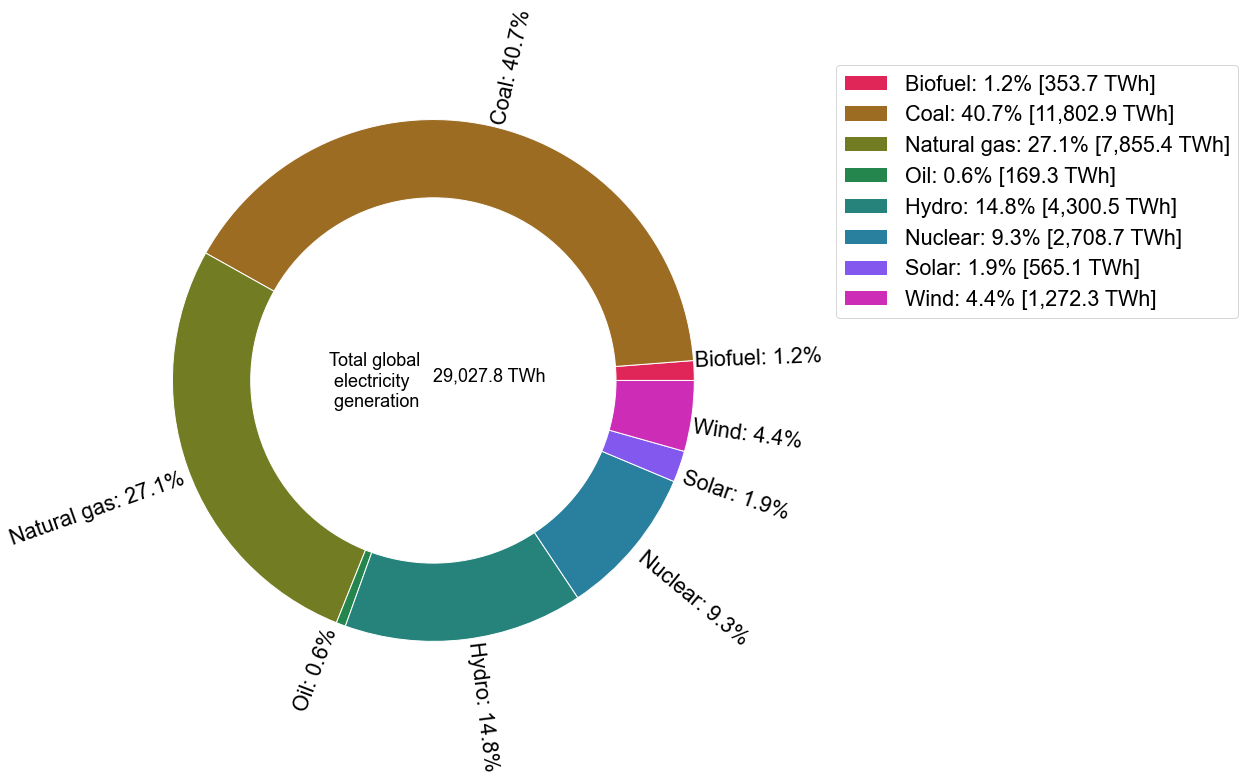

In [214]:
color_list = sns.husl_palette(8 ,l = .5)
labels_list = []
legend_list =[]
#i = 0
total_energy = electric_generation['Energy (GWh)'].sum()

    
for l, e in zip(electric_generation['Source'], electric_generation['Energy (GWh)']):
    p = e / total_energy * 100
    p = np.round(p,decimals = 1)
    labels_list.append(l +': ' +str(p) +'%')
    e = e / 1000
    e = np.round(e,1)
    e = "{:,}".format(e)
    legend_list.append(l +': ' +str(p) +'% ' +'[' +str(e) +' TWh]')
    #i += 1
total_energy = total_energy / 1000
total_energy = np.round(total_energy,1)
total_energy = "{:,}".format(total_energy)
fig, ax = plt.subplots()
electric_generation['Energy (GWh)'].plot(kind='pie', labels = labels_list, figsize=(12, 12), colors = color_list, labeldistance=1., rotatelabels = True)
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.legend(legend_list, loc="best", bbox_to_anchor=(1.1, 1))
plt.text(-.4, -0.1, "Total global \n electricity \n generation")
plt.text(0.0, -.0, str(total_energy) +' TWh')
plt.ylabel('')

### Question 2: Global energy consumption by end use type (2010 - 2018)
* Households
* Industry 
* Transport 
* Agriculture
* Commercial / public services

In [51]:
# read data from UN site: http://data.un.org/Explorer.aspx 
years = ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
df_by_year = []
for y in years:
    url_year = '%3byr%3a' +y
    url = url_base + 'EL' + url_year
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    number_of_pages = soup.find('span', {'id':'spanPageCountB'}).get_text()
    df_list = []
    for i in range(1, int(number_of_pages)):
        url_by_page = url + url_page +str(i)
        df = pd.read_html(url_by_page)
        df_list.append(df[1])
    df = pd.concat(df_list)
    df_by_year.append(df)
    print('Finished webscraping year: ' +y)


http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2008
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2009
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2010
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2011
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2012
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2013
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2014
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2015
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2016
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2017
http://data.un.org/Data.aspx?d=EDATA&f=cmID%3aEL%3byr%3a2018


In [54]:
energy_cons = pd.concat(df_by_year)

##### Notes about 'transport'
'Electricity - Consumption by transport' includes:
* 'Electricity - Consumption by pipeline transport',
* 'Electricity - Consumption by rail',
* 'Electricity - Consumption by road',
*'Electricity - Consumption not elsewhere specified (transport)'

##### Notes about 'industry'
'Electricity - Consumption by manufacturing, construction and non-fuel industry' includes:
* 'Electricity - Consumption by iron and steel',
* 'Electricity - Consumption by chemical and petrochemical',
* 'Electricity - Consumption by other manuf., const. and non-fuel ind.'
* 'Electricity - Consumption by non-ferrous metals',
* 'Electricity - Consumption by non-metallic minerals',
* 'Electricity - Consumption by transport equipment',
* 'Electricity - Consumption by machinery',
* 'Electricity - Consumption by mining and quarrying',
* 'Electricity - Consumption by food and tobacco',
* 'Electricity - Consumption by paper, pulp and print',
* 'Electricity - Consumption by wood and wood products',
* 'Electricity - Consumption by construction',
* 'Electricity - Consumption by textile and leather',
* 'Electricity - Consumption not elsewhere specified (industry)'

In [121]:
end_use_cols = [
'Electricity - Consumption by commercial and public services',
'Electricity - Consumption by households',
'Electricity - Consumption by manufacturing, construction and non-fuel industry',
'Electricity - Consumption by transport',
'Electricity - Consumption in agriculture, forestry and fishing']


In [123]:
elec_by_end_use = []
i = 0
for c in end_use_cols:
    df = energy_cons[energy_cons['Commodity - Transaction'] == c]
    sum_by_year = df.groupby(['Year']).agg({'Quantity':'sum'})
    sum_by_year = sum_by_year.reset_index()
    if('commercial' in c):
        end_use = 'Commercial and public services'
    elif('households' in c):
        end_use = 'Households'
    elif('industry' in c):
        end_use = 'Industry'
    elif('transport' in c):
        end_use = 'Transport'
    elif('agriculture' in c):
        end_use = 'Agriculture'
    else:
        print('Energy consumption end use not listed')
    sum_by_year = sum_by_year.rename(columns ={'Quantity':end_use})
    if(i > 0):
        sum_by_year = sum_by_year.drop(columns = ['Year'])
    elec_by_end_use.append(sum_by_year)
    i += 1

elec_by_end_use = pd.concat(elec_by_end_use, axis=1)

Text(0.5, 0, '')

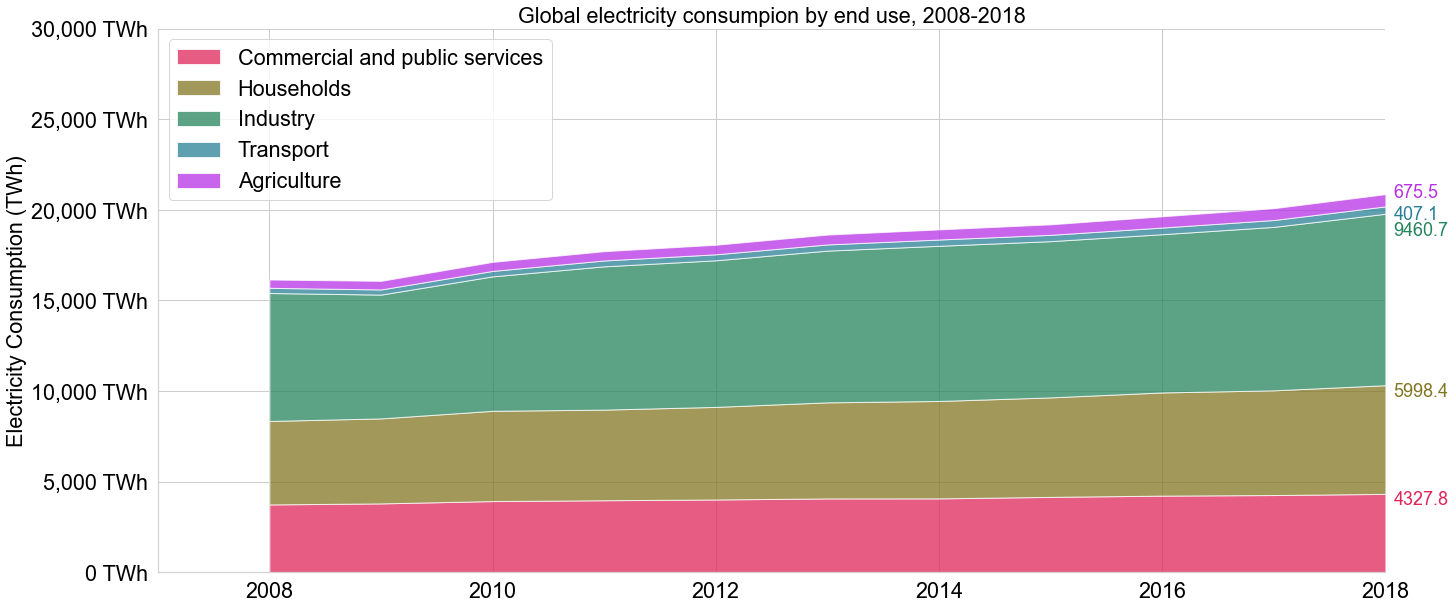

In [212]:
fig, ax = plt.subplots(1, 1)
end_use_labels = elec_by_end_use.columns
color_list = sns.husl_palette(5 ,l = .5)
plt.stackplot(elec_by_end_use['Year'],elec_by_end_use['Commercial and public services'], elec_by_end_use['Households'], elec_by_end_use['Industry'], elec_by_end_use['Transport'], elec_by_end_use['Agriculture'], labels=[end_use_labels[1],end_use_labels[2],end_use_labels[3],end_use_labels[4],end_use_labels[5]], colors = color_list, alpha = 0.75)
running_var_max = 0
i = 0
for var in (elec_by_end_use['Commercial and public services'], elec_by_end_use['Households'], elec_by_end_use['Industry'], elec_by_end_use['Transport'], elec_by_end_use['Agriculture']):
        running_var_max +=var.max()
        value = var.max() / 1000
        value = np.round(value,1)
        if(i == 0 or i ==2):
            running_var_max -= 600000
        if(i > 2):
            running_var_max += 500000
        plt.annotate(value, xy=(1, running_var_max), xytext=(8, 0), 
                 xycoords=('axes fraction', 'data'), textcoords='offset points', color = color_list[i])
        i += 1
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + ' TWh'))
plt.ylim(0,30000000)
plt.xlim(2007, 2018)
plt.legend(loc = 'upper left')
plt.ylabel('Electricity Consumption (TWh)')
plt.title('Global electricity consumpion by end use, 2008-2018')
plt.xlabel('')

### Question 3: 2 additional questions to ask same dataset

* Question 1: Year-over-year growth or decline of electricity generation from different sources (i.e. is coal becoming less popular as a source of electricity? are renewables growing as an electricity supply source?)

* Question 2: How are end-uses changing over time in different regions of the world? Are end-uses changing consistently across the world or are there regional differences?